# Desafío Data Scientist - LATAM Airlines

## 0. Introducción

Como parte del desafío LATAM se presenta una serie de problemas a responder a lo largo de este notebook en python 3. Para lo cual, se ha provisto de un archivo CSV con el dataset a usar y archivos vinculados a la solución (url: https://github.com/Mishagk/LATAM-Desafio-DS). 
<br><br>
Con todo esto, la principal problematica a responder o desarrollar es *"predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL)"*

## 1. Librerias

Previo a ejecutar este notebook se creará un entorno virtual en Anaconda (env name: latam1) en python 3.9.13.

In [66]:
# Version de python en entorno virtual de Anaconda
!python --version

Python 3.9.13


NOTA: Es importante que se ejecute el código con la versión de python indicada ya que las librerias dependen del mismo

Se procede a instalar las principales librerias a utilizar

In [67]:
# Instalar principales librerias (NOTA: Algunas librerias tienen versiones especificas)

!pip install scikit-learn==1.1.3
!pip install numpy==1.23.4
!pip install pandas
!pip install scipy
!pip install seaborn
!pip install matplotlib

Con las librerias instaladas, se realiza la importación de las mismas

In [68]:
# Importar librerias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sys

import warnings
warnings.filterwarnings("ignore")  # Ignorar las advertencias, pero SI muestra los errores

# 2. Carga de Datos

In [69]:
# Leer datos desde la URL de github

# URL a github
url_github = "https://raw.githubusercontent.com/Mishagk/LATAM-Desafio-DS/master/dataset_SCL.csv"

# leer datos
data = pd.read_csv(url_github,sep=',',quotechar='"')

# ver primeras 5 filas
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1.0,1.0,2017.0,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2.0,1.0,2017.0,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3.0,1.0,2017.0,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4.0,1.0,2017.0,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5.0,1.0,2017.0,Jueves,I,American Airlines,Santiago,Miami


In [70]:
# informacion general de tabla

print('Cantidad columnas :',data.shape[1])
print('Cantidad registros:',data.shape[0])

Cantidad columnas : 18
Cantidad registros: 68206


El dataset leido contiene registro de los vuelos de aviones que aterrizaron o despegaron en Santiago de Chile (SCL). La descripción de cada variable:
<br>
- `Fecha-I` : Fecha y hora programada del vuelo. *(ordinal)*
- `Vlo-I` : Número de vuelo programado. *(ordinal)*
- `Ori-I` : Código de ciudad de origen programado. *(nominal)*
- `Des-I` : Código de ciudad de destino programado. *(nominal)*
- `Emp-I` : Código aerolínea de vuelo programado. *(nominal)*
- `Fecha-O` : Fecha y hora de operación del vuelo. *(ordinal)*
- `Vlo-O`: Número de vuelo de operación del vuelo. *(nominal)*
- `Ori-O` : Código de ciudad de origen de operación. *(nominal)*
- `Des-O` : Código de ciudad de destino de operación. *(nominal)*
- `Emp-O` : Código aerolínea de vuelo operado. *(nominal)*
- `DIA` : Día del mes de operación del vuelo. *(ordinal)*
- `MES` : Número de mes de operación del vuelo. *(ordinal)*
- `AÑO` : Año de operación del vuelo. *(ordinal)*
- `DIANOM` : Día de la semana de operación del vuelo. *(ordinal)*
- `TIPOVUELO` : Tipo de vuelo, I =Internacional, N =Nacional. *(nominal)*
- `OPERA` : Nombre de aerolínea que opera. *(nominal)*
- `SIGLAORI` : Nombre ciudad origen. *(nominal)*
- `SIGLADES` : Nombre ciudad destino. *(nominal)*
<br><br>Es importante considerar que al lado derecho de cada una se colocó si se puede considerar del tipo **`ordinal`** o **`nominal`**. Esto significa que en caso de ser ordinal, poseen un orden entre los valores, por ejemplo los dias, el orden: es `lunes`, `martes`, `miercoles`, `jueves`, etc. Por el otro lado, variables nominales como aerolinea no poseen un orden natural, no se puede decir por ejemplo que `LAN` es mayor de `TAM` o `SUK` de forma natural.

## 3. Analisis y Preparación de Datos

### 3.1. Calidad de Datos

En esta sección revisaremos el estado de los datos en su condición de origen.

In [129]:
# Ver todas las columnas disponibles, la cantidad de datos nulos y el tipo de datos según se haya leido
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68206 entries, 0 to 67669
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  int16         
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68206 non-null  int16         
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int8          
 11  MES        68206 non-null  int8          
 12  AÑO        68206 non-null  int16         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [131]:
# Ver cuantos datos "vacios" o "nulos" se tienen desde informacion origen (data raw)
data.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        0
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
MESNOM       0
dtype: int64

Observamos que hay **39** registros con datos nulos en la mayoría de columnas, acontinuación veremos dichos casos:

In [132]:
# Revisar los casos que poseen al menos 1 dato NaN en el registro
data_nan = data[data.isnull().any(axis=1)].copy()

# Datos sin NaN - La data con datos completos
data_com = data[~data.index.isin(data_nan.index)].copy()

# info
print('Cantidad de registros completos:',data_com.shape[0])
print('Cantidad de registros con algun NAN:',data_nan.shape[0])

# ver datos con NaN
data_nan.head()

Cantidad de registros completos: 68206
Cantidad de registros con algun NAN: 0


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM


Segun los datos extraidos se observa que estos 39 casos, al leerse mediante pd.read_csv(), no logró interpretar las 18 columnas, sino que lo leyó como un unico valor en texto.

In [133]:
# Ver un caso de la mala lectura
data_nan.iloc[1,0] # seleccionar fila 1, columna 0

IndexError: index 1 is out of bounds for axis 0 with size 0

Al observarse ese registro, al final esta el texto **"Curitiba, Bra."**. Con esto podemos inferir que la coma (`","`) entre `Curitiba` y `Bra.` posiblemente fue el que generó este error de lectura, dado que interpretó como 19 columnas en vez de 18.
<br><br>
Dada la lógica detectada, se hará un pequeño codigo que permita convertir la coma (`,`) a guion (`-`) con el fin de corregir estos casos. Esto se podría corregir desde el archivo origen al crear un csv con separador tipo `";"` para resolverlo. En el presente desarrollo, se usarán los datos según fueron provistos, sin alterar el archivo CSV origen.
<br><br>
NOTA: En caso de aplicar lo último, el codigo de lectura de datos cambiaría a: `pd.read_csv(url_github,sep=';')`

In [ ]:
# Script de corrección y separación de valores

# leemos fila por fila de los datos extraidos
for i in range(data_nan.shape[0]):
    
    # Solo aquellas filas que posean NaN en todas excepto la primera columna NaN
    if(data_nan.iloc[i,:].isnull().sum() == 17):
        
        # extraer sub-cadena entre ""
        subtext = re.search('"(.*)"',data_nan.iloc[i,0]).group(1)
        
        # Corregir la subcadena de texto mediante el reemplazo de caracteres
        subtext_new = subtext.replace(",","-").replace("- ","-")
        texto = data_nan.iloc[i,0].replace(subtext,subtext_new).replace('"','') # Reemplazar texto completo
        
         # dividir en los valores de las columnas
        lista_valores = texto.split(",")
        
        # En caso en la lista obtenida existan 18 valores se actualiza
        if(len(lista_valores) == 18):
            data_nan.iloc[i,:] = lista_valores

# Lista valores unicos con casos detectados
print("Lista de valores en SIGLADES corregidos: ",data_nan.iloc[1:,:]["SIGLADES"].unique().tolist())

# ver valores corregidos
data_nan.head()

Lista de valores en SIGLADES corregidos:  ['Curitiba-Bra.', 'San Juan-Arg.', 'Pisco-Peru']


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima
17059,2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,8,3,2017,Miercoles,I,Grupo LATAM,Santiago,Curitiba-Bra.
17060,2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03-06 14:26:00,1357,SCEL,SBCT,LAN,6,3,2017,Lunes,I,Grupo LATAM,Santiago,Curitiba-Bra.
39316,2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08-10 20:11:00,8541,SCEL,SBCT,ONE,10,8,2017,Jueves,I,Oceanair Linhas Aereas,Santiago,Curitiba-Bra.
55332,2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10-03 08:00:00,7896,SCEL,SANU,DSM,3,10,2017,Martes,I,Grupo LATAM,Santiago,San Juan-Arg.


Solo para validar que efectivamente estos valores de texto son unicos y no hay otras ciudades iguales que no fueron afectadas.

In [ ]:
# [1] Seleccionar datos del dataframe con NaN corregido
data_nan[(data_nan["SIGLADES"].str.contains("Curitiba",regex=0,na=0)) |
     (data_nan["SIGLADES"].str.contains("San Juan",regex=0,na=0)) |
     (data_nan["SIGLADES"].str.contains("Pisco",regex=0,na=0))].head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
17059,2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,8,3,2017,Miercoles,I,Grupo LATAM,Santiago,Curitiba-Bra.
17060,2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03-06 14:26:00,1357,SCEL,SBCT,LAN,6,3,2017,Lunes,I,Grupo LATAM,Santiago,Curitiba-Bra.
39316,2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08-10 20:11:00,8541,SCEL,SBCT,ONE,10,8,2017,Jueves,I,Oceanair Linhas Aereas,Santiago,Curitiba-Bra.
55332,2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10-03 08:00:00,7896,SCEL,SANU,DSM,3,10,2017,Martes,I,Grupo LATAM,Santiago,San Juan-Arg.
55333,2017-10-05 08:00:00,7896,SCEL,SANU,LAN,2017-10-05 07:59:00,7896,SCEL,SANU,DSM,5,10,2017,Jueves,I,Grupo LATAM,Santiago,San Juan-Arg.


In [ ]:
# [2] Seleccionar datos del dataframe completo
data_com[(data_com["SIGLADES"].str.contains("Curitiba",regex=0,na=0)) |
     (data_com["SIGLADES"].str.contains("San Juan",regex=0,na=0)) |
     (data_com["SIGLADES"].str.contains("Pisco",regex=0,na=0))].head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES


Vemos que en **[2]** no se encontró ningun valor (numero filas=0) en la columna `SIGLADES` que tuviese las mismas palabras iniciales que de los 39 registros corregidos (`"Curitiba"`,`"San Juan"`,`"Pisco"`), por lo que esta corrección no va afectar a otros registros. <br>(*Ejemplo*: Caso de valor `"Curitiba-Bra"` y otro `"Curitiba;Bra"`, en si ambos corresponden al mismo. Pero no va ocurrir segun vemos)

In [ ]:
# Obtener un dataframe consolidado entre los dataframes completos y NaN corregidos. Adicional, ver la cantidad de registros nulos

try:
    # Concatenar ambos dataframes
    data = pd.concat([data_com.copy(),data_nan.copy()])

    # Borramos de memoria los anteriores
    del data_com, data_nan
    
except:
    print('[Info Advertencia] Se borraron previamente los dataframes')

# info
print('Cantidad de registros al concatenar dataframes:',data.shape[0])
print('--------------------------------------------------------')

# Revisamos nuevamente los datos nulos en la nueva data
print('Cantidad de datos NaN por variable:')
data.isnull().sum()

Cantidad de registros al concatenar dataframes: 68206
--------------------------------------------------------
Cantidad de datos NaN por variable:


Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

Observamos que solo hay **1** registro con NaN, donde el campo faltante es el **número de vuelo de operación** (`Vlo-O`)

In [ ]:
data[data.isnull().any(axis=1)].copy()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima


Solo para ver si podemos completar el dato faltante, filtramos aquellos registros con columnas comunes como `Emp-I`,`Emp-O` y `OPERA`

In [ ]:
data[(data["Emp-I"]=="LAW") &
     (data["Emp-O"]=="56R") & 
     (data["OPERA"]=="Latin American Wings")].sort_values(by=["Fecha-I","Vlo-I","Ori-I","Des-I","Emp-I"])

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6094,2017-01-02 01:15:00,704,SCEL,SPJC,LAW,2017-01-02 01:34:00,704,SCEL,SPJC,56R,2.0,1.0,2017.0,Lunes,I,Latin American Wings,Santiago,Lima
6107,2017-01-03 01:15:00,1704,SCEL,SPJC,LAW,2017-01-03 02:38:00,1700,SCEL,SPJC,56R,3.0,1.0,2017.0,Martes,I,Latin American Wings,Santiago,Lima
6079,2017-01-04 01:15:00,700,SCEL,SPJC,LAW,2017-01-04 02:25:00,700,SCEL,SPJC,56R,4.0,1.0,2017.0,Miercoles,I,Latin American Wings,Santiago,Lima
6095,2017-01-05 01:15:00,704,SCEL,SPJC,LAW,2017-01-05 01:15:00,708,SCEL,SPJC,56R,5.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima
6080,2017-01-06 01:15:00,700,SCEL,SPJC,LAW,2017-01-06 02:18:00,700,SCEL,SPJC,56R,6.0,1.0,2017.0,Viernes,I,Latin American Wings,Santiago,Lima
6082,2017-01-08 01:15:00,700,SCEL,SPJC,LAW,2017-01-08 02:01:00,700,SCEL,SPJC,56R,8.0,1.0,2017.0,Domingo,I,Latin American Wings,Santiago,Lima
6096,2017-01-09 01:15:00,704,SCEL,SPJC,LAW,2017-01-09 02:15:00,704,SCEL,SPJC,56R,9.0,1.0,2017.0,Lunes,I,Latin American Wings,Santiago,Lima
6097,2017-01-10 01:15:00,704,SCEL,SPJC,LAW,2017-01-10 02:36:00,704,SCEL,SPJC,56R,10.0,1.0,2017.0,Martes,I,Latin American Wings,Santiago,Lima
6083,2017-01-11 01:15:00,700,SCEL,SPJC,LAW,2017-01-11 01:20:00,700,SCEL,SPJC,56R,11.0,1.0,2017.0,Miercoles,I,Latin American Wings,Santiago,Lima
6098,2017-01-12 01:15:00,704,SCEL,SPJC,LAW,2017-01-12 01:55:00,702,SCEL,SPJC,56R,12.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima


Observamos la ultima fila, el registro con el dato `NaN`, hay 2 vuelos para la fecha del 2017-01-19 (`Fecha_I`). Debido a que hay casos donde el `Vlo-I` no es igual a `Vlo-O`, no podriamos inferir necesariamente que `Vlo-O` para dicho caso tenga que ser valor **200**.
<br><br>
Para validar esto, podemos revisar aquellos casos donde se tuvo valor de `Vlo-I`=200 para ver si podria o no darse otro valor igual en `Vlo-O`

In [ ]:
# Extraer valores 200 excepto aquellos registros con algun NaN
valida_Vlo = data[(data["Vlo-I"]=="200") & (~data.isnull().any(axis=1))][["Vlo-I","Vlo-O"]].copy()

# crear el par de valores existentes "Vlo-I_Vlo-O"
valida_Vlo["par"] = valida_Vlo["Vlo-I"].map(str) + "_" + valida_Vlo["Vlo-O"].map(str)

# Ver lista con valores encontrados
valida_Vlo["par"].unique().tolist()

['200_200']

Mediante esto vemos que todos aquellos vuelos registrados que tienen valor de **200** en `Vlo-I` también tienen ese valor en `Vlo-O`. Por lo que con mayor confianza podemos asignar este valor al dato faltante.

In [ ]:
# Actualizar registro
indice_corrige = data[data.isnull().any(axis=1)].index

# Corrige - Coloca valor de forma manual
data.loc[indice_corrige,"Vlo-O"] = "200"

# ver dato corregido
data.loc[indice_corrige,:]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,200,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima


### 3.2. Formateo y limpieza de datos

Mediante la observación a priori de los datos y usando la descripción del diccionario de cada variable se realizará el formateo de cada una.

In [ ]:
# Creamos un backup previo al formateo de datos, para evaluar los casos donde el formato generará NaN por error
data_bkp = data.copy()

In [ ]:
# Convertir de formato segun cada columna

# fecha
data["Fecha-I"] = pd.to_datetime(data["Fecha-I"],format="%Y-%m-%d %H:%M:%S")
data["Fecha-O"] = pd.to_datetime(data["Fecha-O"],format="%Y-%m-%d %H:%M:%S") 

# entero
data["Vlo-I"] = pd.to_numeric(data["Vlo-I"], errors="coerce",downcast="integer") 
data["Vlo-O"] = pd.to_numeric(data["Vlo-O"], errors="coerce",downcast="integer")

# texto
data["Ori-I"] = data["Ori-I"].map(str) 
data["Des-I"] = data["Des-I"].map(str) 
data["Emp-I"] = data["Emp-I"].map(str) 
data["Ori-O"] = data["Ori-O"].map(str) 
data["Des-O"] = data["Des-O"].map(str) 
data["Emp-O"] = data["Emp-O"].map(str)

# entero
data["DIA"] = pd.to_numeric(data["DIA"], errors="coerce",downcast="integer")
data["MES"] = pd.to_numeric(data["MES"], errors="coerce",downcast="integer")
data["AÑO"] = pd.to_numeric(data["AÑO"], errors="coerce",downcast="integer")

# texto
data["DIANOM"] = data["DIANOM"].map(str) 
data["TIPOVUELO"] = data["TIPOVUELO"].map(str) 
data["OPERA"] = data["OPERA"].map(str)
data["SIGLAORI"] = data["SIGLAORI"].map(str) 
data["SIGLADES"] = data["SIGLADES"].map(str)

# Ver tipo de datos de salida
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68206 entries, 0 to 67669
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68201 non-null  float64       
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68190 non-null  float64       
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int8          
 11  MES        68206 non-null  int8          
 12  AÑO        68206 non-null  int16         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [ ]:
# ver datos formateados
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-01 23:33:00,226.0,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-02 23:39:00,226.0,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-03 23:39:00,226.0,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-04 23:33:00,226.0,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-05 23:28:00,226.0,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [ ]:
# Datos que al formatear no se pudo y se cambiaron a NaN
data[data.isnull().any(axis=1)].copy().head(8)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71.0,SCEL,SCIE,SKU,2017-03-30 10:50:00,NaN,SCEL,SCIE,SKU,30,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071.0,SCEL,SCIE,SKU,2017-03-22 11:00:00,NaN,SCEL,SCIE,SKU,22,3,2017,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201.0,SCEL,SCIE,LXP,2017-03-22 11:50:00,NaN,SCEL,SCIE,LXP,22,3,2017,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71.0,SCEL,SCIE,SKU,2017-04-25 09:29:00,NaN,SCEL,SCIE,SKU,25,4,2017,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43.0,SCEL,SCIE,LAW,2017-04-06 21:24:00,NaN,SCEL,SCIE,JMR,6,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,NaN,SCEL,SUMU,AAL,2017-05-13 21:52:00,989.0,SCEL,SUMU,AAL,13,5,2017,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401.0,SCEL,LFPG,AFR,2017-05-26 10:03:00,NaN,SCEL,LFPG,AFR,26,5,2017,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401.0,SCEL,LFPG,AFR,2017-05-28 09:43:00,NaN,SCEL,LFPG,AFR,28,5,2017,Domingo,I,Air France,Santiago,Paris


In [ ]:
# De los datos backup vemos los valores previos al formateo
indice_lee = data[data.isnull().any(axis=1)].index
data_bkp[data_bkp.index.isin(indice_lee)].head(8)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71R,SCEL,SCIE,SKU,30.0,3.0,2017.0,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71R,SCEL,SCIE,SKU,22.0,3.0,2017.0,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201R,SCEL,SCIE,LXP,22.0,3.0,2017.0,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71R,SCEL,SCIE,SKU,25.0,4.0,2017.0,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43R,SCEL,SCIE,JMR,6.0,4.0,2017.0,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,989P,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13.0,5.0,2017.0,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401A,SCEL,LFPG,AFR,26.0,5.0,2017.0,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401B,SCEL,LFPG,AFR,28.0,5.0,2017.0,Domingo,I,Air France,Santiago,Paris


Con lo anterior, evidenciamos que las columnas `Vlo-I` y `Vlo-O` hay algunos valores que poseen una letra al final (`A`,`R`,`P`). Esto desde el negocio podría tener un significado específico pero dado que el diccionario nos indica que estos deberían ser numericos y en vista de que son una gran minoría de datos, se extraerán las letras finales.

In [ ]:
# Aplicar backup
data = data_bkp.copy() # restaurar valores previos

# Extraer solo los caracteres numericos y filtrar las letras
data["Vlo-I"] = data["Vlo-I"].map(str).str.extract('([0-9]*)')
data["Vlo-O"] = data["Vlo-O"].map(str).str.extract('([0-9]*)')

# Ver los datos donde se realizaro la correccion
data[data_bkp.index.isin(indice_lee)].head(8)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71,SCEL,SCIE,SKU,30.0,3.0,2017.0,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71,SCEL,SCIE,SKU,22.0,3.0,2017.0,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201,SCEL,SCIE,LXP,22.0,3.0,2017.0,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71,SCEL,SCIE,SKU,25.0,4.0,2017.0,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43,SCEL,SCIE,JMR,6.0,4.0,2017.0,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,989,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13.0,5.0,2017.0,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401,SCEL,LFPG,AFR,26.0,5.0,2017.0,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401,SCEL,LFPG,AFR,28.0,5.0,2017.0,Domingo,I,Air France,Santiago,Paris


In [ ]:
# Convertir de formato segun cada columna

# fecha
data["Fecha-I"] = pd.to_datetime(data["Fecha-I"],format="%Y-%m-%d %H:%M:%S")
data["Fecha-O"] = pd.to_datetime(data["Fecha-O"],format="%Y-%m-%d %H:%M:%S") 

# entero
data["Vlo-I"] = pd.to_numeric(data["Vlo-I"], errors="coerce",downcast="integer") 
data["Vlo-O"] = pd.to_numeric(data["Vlo-O"], errors="coerce",downcast="integer")

# texto
data["Ori-I"] = data["Ori-I"].map(str) 
data["Des-I"] = data["Des-I"].map(str) 
data["Emp-I"] = data["Emp-I"].map(str) 
data["Ori-O"] = data["Ori-O"].map(str) 
data["Des-O"] = data["Des-O"].map(str) 
data["Emp-O"] = data["Emp-O"].map(str)

# entero
data["DIA"] = pd.to_numeric(data["DIA"], errors="coerce",downcast="integer")
data["MES"] = pd.to_numeric(data["MES"], errors="coerce",downcast="integer")
data["AÑO"] = pd.to_numeric(data["AÑO"], errors="coerce",downcast="integer")

# texto
data["DIANOM"] = data["DIANOM"].map(str) 
data["TIPOVUELO"] = data["TIPOVUELO"].map(str) 
data["OPERA"] = data["OPERA"].map(str)
data["SIGLAORI"] = data["SIGLAORI"].map(str) 
data["SIGLADES"] = data["SIGLADES"].map(str)

# Ver tipo de datos de salida
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68206 entries, 0 to 67669
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  int16         
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68206 non-null  int16         
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int8          
 11  MES        68206 non-null  int8          
 12  AÑO        68206 non-null  int16         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [ ]:
# ver datos
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Si bien la columna del numero de mes nos permite ver esta variable como númerica, o en otra perspectiva del tipo categorica ordinal, dado que cada mes posee un orden en progresión. También se podría colocar el nombre del mes para mejor lectura del mismo.

In [ ]:
# Crear variable nombre del mes

# diccionario con el mapeo de los valores
mes_dic = {
    1:"Enero",
    2:"Febrero",
    3:"Marzo",
    4:"Abril",
    5:"Mayo",
    6:"Junio",
    7:"Julio",
    8:"Agosto",
    9:"Setiembre",
    10:"Octubre",
    11:"Noviembre",
    12:"Diciembre"}

# Crear columna nueva con el nombre de los meses
data["MESNOM"] = data["MES"].apply(lambda x:mes_dic[x])
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,Enero
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,Enero
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,Enero
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,Enero
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,Enero


### 3.3. Exploración de variables

En este segmento analizaremos como estan distribuidas las variables. Además, esto permitirá seguir afinando la limpieza y perfilamiento de los datos.

<b>Variables Categoricas

In [ ]:
# Ver descripcion general de variables categoricas
datacat = data.select_dtypes(include=["object"])
datacat.head(8)

,Ori-I,Des-I,Emp-I,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM
0,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami,Enero
1,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Lunes,I,American Airlines,Santiago,Miami,Enero
2,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Martes,I,American Airlines,Santiago,Miami,Enero
3,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Miercoles,I,American Airlines,Santiago,Miami,Enero
4,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Jueves,I,American Airlines,Santiago,Miami,Enero
5,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Sabado,I,American Airlines,Santiago,Miami,Enero
6,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Sabado,I,American Airlines,Santiago,Miami,Enero
7,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami,Enero


In [ ]:
# Descripcion general de los datos
datacat.describe()

,Ori-I,Des-I,Emp-I,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM
count,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206
unique,1,64,30,1,63,32,7,2,23,1,62,12
top,SCEL,SCFA,LAN,SCEL,SCFA,LAN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires,Diciembre
freq,68206,5787,37611,68206,5786,20988,10292,36966,40892,68206,6335,6356


----------------------------------------------
Variable:  Ori-I
Cantidad de registros por valor:


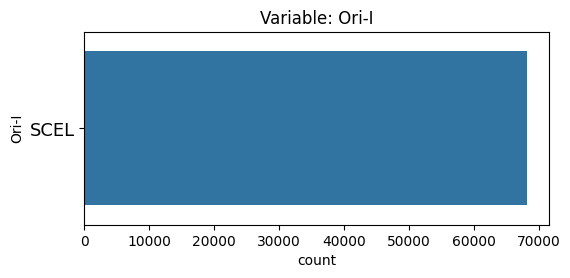

----------------------------------------------
Variable:  Des-I
Valores con mas registros:
  Des-I  suma     %
0  SCFA  5787  8.48
1  SPJC  5270  7.73
2  SCCF  5145  7.54
3  SCTE  4357  6.39
4  SCIE  3995  5.86
5  SCDA  3747  5.49
6  SBGR  3570  5.23
7  SAEZ  3240  4.75
8  SABE  3094  4.54
9  SCQP  2583  3.79
Valores con menos registros:
   Des-I  suma    %
59  SARI     1  0.0
60  SBFI     1  0.0
61  SLCB     1  0.0
62  SEQM     1  0.0
63  SEQU     1  0.0


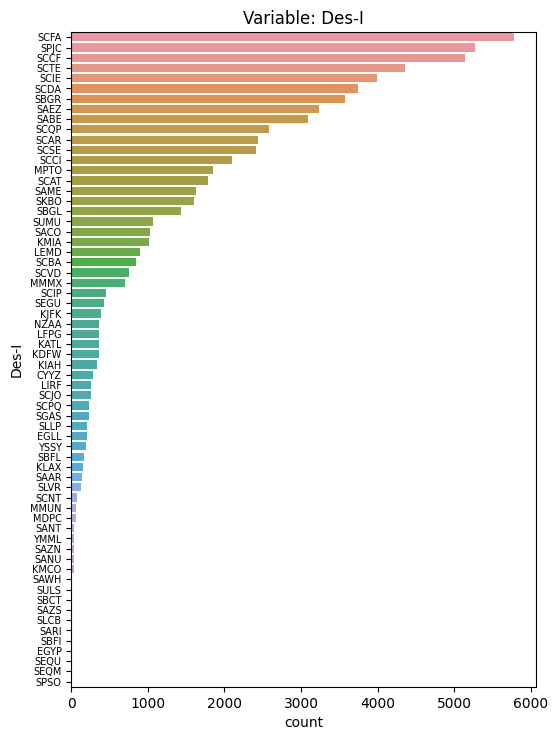

----------------------------------------------
Variable:  Emp-I
Valores con mas registros:
  Emp-I   suma      %
0   LAN  37611  55.14
1   SKU  14298  20.96
2   TAM   3049   4.47
3   ARG   1949   2.86
4   CMP   1850   2.71
5   LAW   1574   2.31
6   AVA   1152   1.69
7   JAT   1095   1.61
8   GLO    806   1.18
9   AAL    757   1.11
Valores con menos registros:
   Emp-I  suma     %
25   PUE    49  0.07
26   LXP     9  0.01
27   LPE     4  0.01
28   DSM     2  0.00
29   LNE     1  0.00


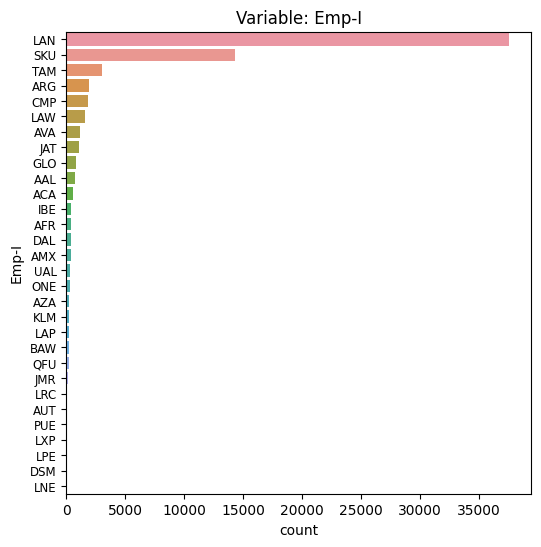

----------------------------------------------
Variable:  Ori-O
Cantidad de registros por valor:


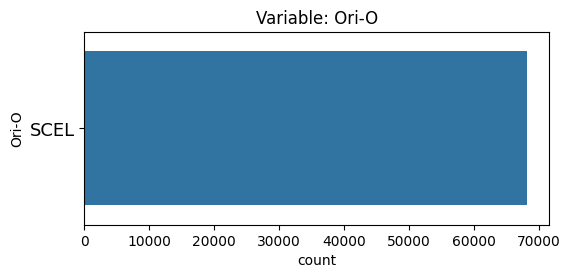

----------------------------------------------
Variable:  Des-O
Valores con mas registros:
  Des-O  suma     %
0  SCFA  5786  8.48
1  SPJC  5270  7.73
2  SCCF  5146  7.54
3  SCTE  4357  6.39
4  SCIE  3993  5.85
5  SCDA  3747  5.49
6  SBGR  3569  5.23
7  SAEZ  3241  4.75
8  SABE  3094  4.54
9  SCQP  2589  3.80
Valores con menos registros:
   Des-O  suma    %
58  SBFI     2  0.0
59  SLCB     1  0.0
60  KIAD     1  0.0
61  SPSO     1  0.0
62  EGYP     1  0.0


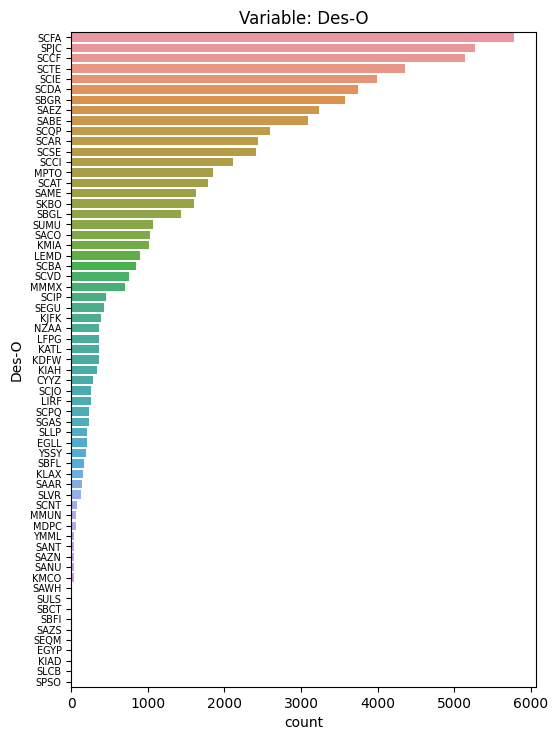

----------------------------------------------
Variable:  Emp-O
Valores con mas registros:
  Emp-O   suma      %
0   LAN  20988  30.77
1   LXP  14558  21.34
2   SKU  14298  20.96
3   TAM   3046   4.47
4   ARG   1946   2.85
5   CMP   1850   2.71
6   JMR   1647   2.41
7   LPE   1214   1.78
8   JAT   1095   1.61
9   AVA    885   1.30
Valores con menos registros:
   Emp-O  suma     %
27   AUT    77  0.11
28   PUE    49  0.07
29   56R    17  0.02
30   48O    10  0.01
31   TPU     2  0.00


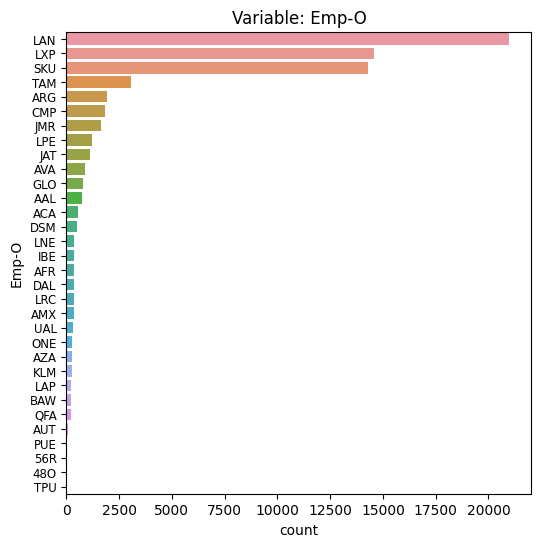

----------------------------------------------
Variable:  DIANOM
Cantidad de registros por valor:


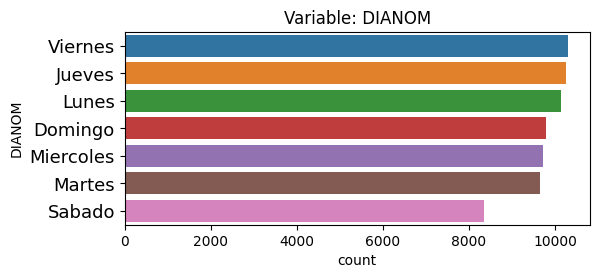

----------------------------------------------
Variable:  TIPOVUELO
Cantidad de registros por valor:


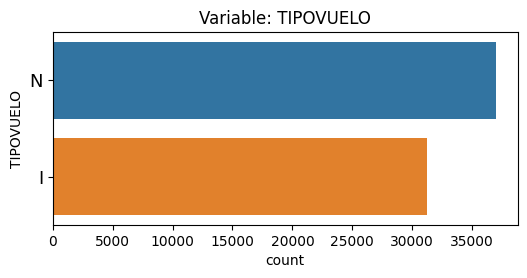

----------------------------------------------
Variable:  OPERA
Valores con mas registros:
                   OPERA   suma      %
0            Grupo LATAM  40892  59.95
1            Sky Airline  14298  20.96
2  Aerolineas Argentinas   1949   2.86
3               Copa Air   1850   2.71
4   Latin American Wings   1674   2.45
5                Avianca   1152   1.69
6           JetSmart SPA   1095   1.61
7              Gol Trans    806   1.18
8      American Airlines    757   1.11
9             Air Canada    565   0.83
Valores con menos registros:
                       OPERA  suma     %
18           British Airways   205  0.30
19            Qantas Airways   195  0.29
20                     Lacsa    92  0.13
21                   Austral    74  0.11
22  Plus Ultra Lineas Aereas    49  0.07


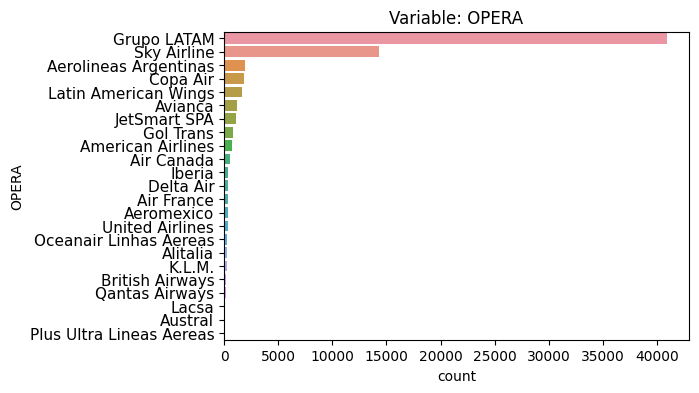

----------------------------------------------
Variable:  SIGLAORI
Cantidad de registros por valor:


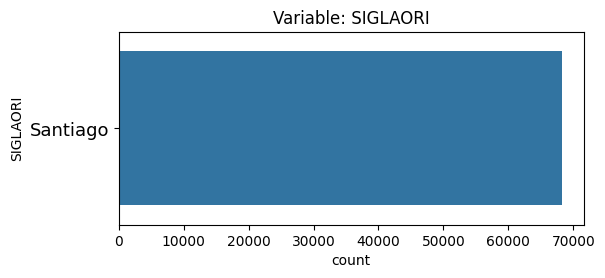

----------------------------------------------
Variable:  SIGLADES
Valores con mas registros:
       SIGLADES  suma     %
0  Buenos Aires  6335  9.29
1   Antofagasta  5786  8.48
2          Lima  5270  7.73
3        Calama  5146  7.54
4  Puerto Montt  4357  6.39
5    Concepcion  3993  5.85
6       Iquique  3747  5.49
7     Sao Paulo  3569  5.23
8        Temuco  2589  3.80
9         Arica  2436  3.57
Valores con menos registros:
            SIGLADES  suma    %
57  Cataratas Iguacu     2  0.0
58        Pisco-Peru     1  0.0
59    Puerto Stanley     1  0.0
60        Cochabamba     1  0.0
61        Washington     1  0.0


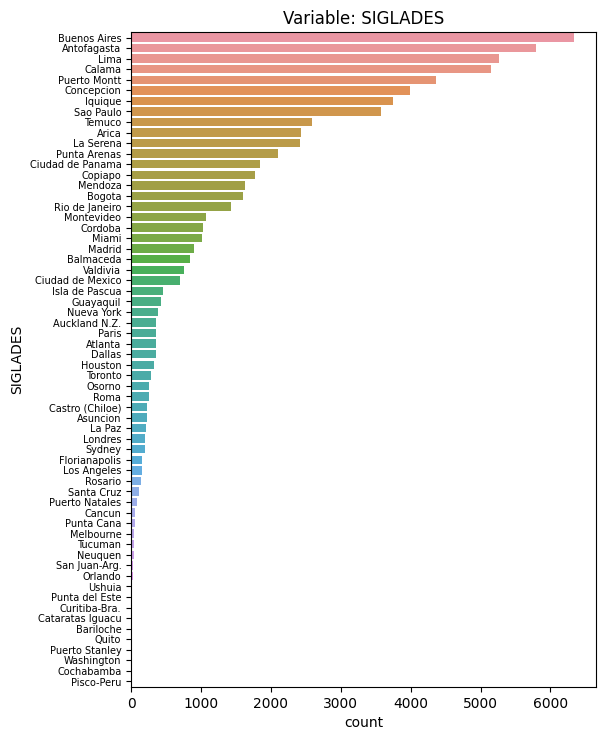

----------------------------------------------
Variable:  MESNOM
Cantidad de registros por valor:


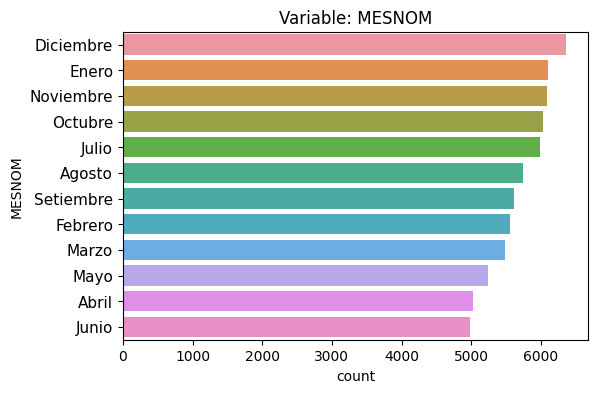

In [ ]:
# Ver detalle de cada variable categorica

# recorrer cada variable categorica
for variable in datacat.columns.tolist():
    
    print('----------------------------------------------')
    print('Variable: ',variable)
    
    conteo = datacat[[variable]] # seleccionar variable
    conteo["suma"] = 1   # variable auxiliar
    conteo = conteo.groupby(variable).agg(np.sum).sort_values("suma",ascending=False).reset_index() # conteo de valores por grupo
    conteo["%"] = np.round(100*conteo["suma"]/np.sum(conteo["suma"]),2) # calculo de porcentajes       
    
    # Mostrar lista/tabla de cantidad de registros por valor unico en la variable
    if(conteo.shape[0] > 20):
        print('Valores con mas registros:')
        print(conteo.head(10))
        print('Valores con menos registros:')
        print(conteo.tail(5))
    else:
        print('Cantidad de registros por valor:')
    
    cantidad = conteo.shape[0] # cantidad de registros en dataframe agrupado
    
    # Determinar aspectos de tamaño de la figura y tamaño de letra
    if(cantidad < 10):
        figy = 2.5
        fontsize = 13.0
    elif(cantidad < 25):
        figy = 4.0
        fontsize = 11.0
    elif(cantidad < 45):
        figy = 6.0
        fontsize = 8.5
    elif(cantidad < 60):
        figy = 7.5
        fontsize = 8.0
    else:
        figy = 8.5 
        fontsize = 7.0   
    
    plt.figure(figsize=(6,figy))
    b = sns.countplot(datacat,y=variable,order=datacat[variable].value_counts().index)
    b.set_yticklabels(datacat[variable].value_counts().index, size = fontsize)
    plt.title("Variable: " + str(variable))
    plt.show()
    

<b>Variables Continuas

In [ ]:
# seleccionar variables continuas
datacon = data.select_dtypes(exclude=["object"]).copy()
datacon.head(8)

,Fecha-I,Vlo-I,Fecha-O,Vlo-O,DIA,MES,AÑO
0,2017-01-01 23:30:00,226,2017-01-01 23:33:00,226,1,1,2017
1,2017-01-02 23:30:00,226,2017-01-02 23:39:00,226,2,1,2017
2,2017-01-03 23:30:00,226,2017-01-03 23:39:00,226,3,1,2017
3,2017-01-04 23:30:00,226,2017-01-04 23:33:00,226,4,1,2017
4,2017-01-05 23:30:00,226,2017-01-05 23:28:00,226,5,1,2017
5,2017-01-06 23:30:00,226,2017-01-07 00:04:00,226,7,1,2017
6,2017-01-07 23:30:00,226,2017-01-07 23:25:00,226,7,1,2017
7,2017-01-08 23:30:00,226,2017-01-08 23:25:00,226,8,1,2017


In [ ]:
# Descripcion general de los datos
datacon.describe()

,Vlo-I,Vlo-O,DIA,MES,AÑO
count,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000
mean,969.827288,967.421092,15.714790,6.622585,2017.000029
std,2029.024762,2026.193621,8.782886,3.523321,0.005415
min,1.000000,1.000000,1.000000,1.000000,2017.000000
25%,150.000000,150.000000,8.000000,3.000000,2017.000000
50%,300.000000,300.000000,16.000000,7.000000,2017.000000
75%,632.000000,637.500000,23.000000,10.000000,2017.000000
max,9956.000000,9956.000000,31.000000,12.000000,2018.000000


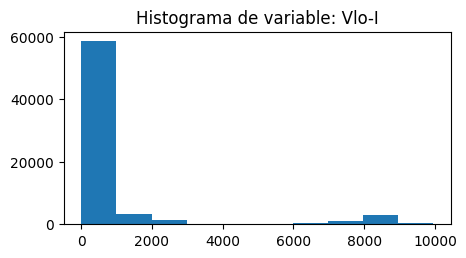

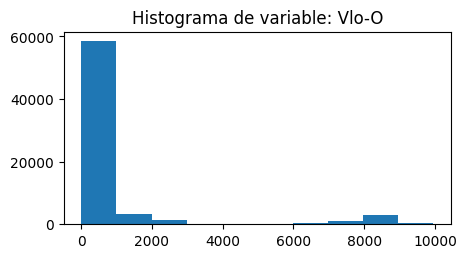

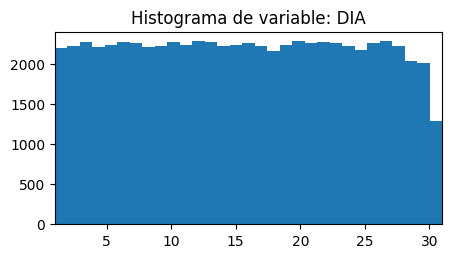

--------------------------
Variable:  DIA
Valores con mas registros:
   DIA  suma     %
0   20  2290  3.36
1   27  2286  3.35
2   12  2284  3.35
3   10  2283  3.35
4    6  2275  3.34
5   22  2272  3.33
6   13  2272  3.33
7    3  2271  3.33
8   16  2268  3.33
9   21  2267  3.32
Valores con menos registros:
    DIA  suma     %
26   25  2179  3.19
27   18  2160  3.17
28   29  2044  3.00
29   30  2020  2.96
30   31  1290  1.89


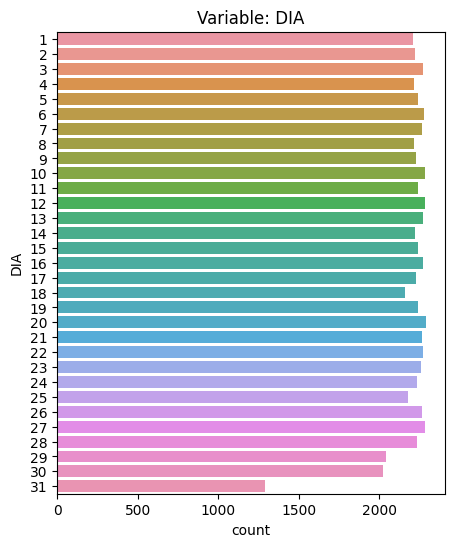

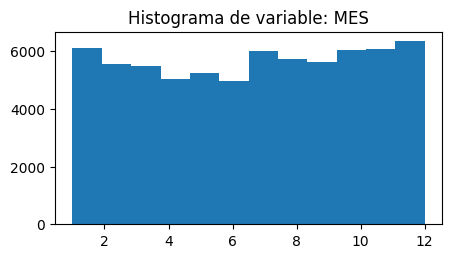

--------------------------
Variable:  MES
Cantidad de registros por valor:


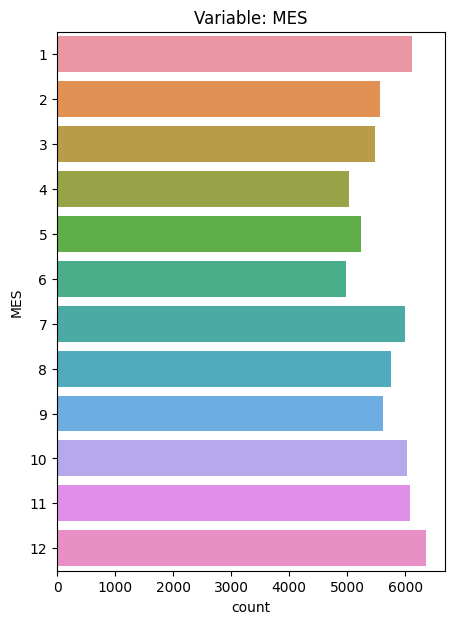

--------------------------
Variable:  AÑO
Cantidad de registros por valor:


In [ ]:
# Analizar variables continuas

# funcion para mostrar distribucion
def graf_cont(datos,variable,figx=5,figy=2.5,tipo=1,min=None,max=None,bins=None):
    
    # Histograma
    if(tipo==1):
        plt.figure(figsize=(figx,figy))
        if(min and max and bins):
            plt.hist(datos[variable],bins=bins)
            plt.xlim([min,max])
        elif(bins):
            plt.hist(datos[variable],bins=bins)
        else:
            plt.hist(datos[variable])
        plt.title('Histograma de variable: ' + str(variable))
        plt.show()
    
    # Conteo de valores unicos
    elif(tipo==2):
        print('--------------------------')
        print('Variable: ',variable)
        conteo = datos[[variable]]
        conteo["suma"] = 1
        conteo = conteo.groupby(variable).agg(np.sum).sort_values("suma",ascending=False).reset_index()
        conteo["%"] = np.round(100*conteo["suma"]/np.sum(conteo["suma"]),2)        
        
        # Imprimir tabla de conteo de registros por cada valor unico de la variable
        if(conteo.shape[0] > 20):
            print('Valores con mas registros:')
            print(conteo.head(10))
            print('Valores con menos registros:')
            print(conteo.tail(5))
        else:
            print('Cantidad de registros por valor:')
        
    elif(tipo==3):
        plt.figure(figsize=(figx,figy))
        b = sns.countplot(datos,y=variable)
        plt.title("Variable: " + str(variable))
        plt.show()

# Graficar-Calcular
graf_cont(datacon,"Vlo-I",tipo=1)
graf_cont(datacon,"Vlo-O",tipo=1)
graf_cont(datacon,"DIA",min=1,max=31,bins=31,tipo=1)
graf_cont(datacon,"DIA",min=1,tipo=2)
graf_cont(datacon,"DIA",figy=6,tipo=3)
graf_cont(datacon,"MES",min=0,max=13,bins=12,tipo=1)
graf_cont(datacon,"MES",tipo=2)
graf_cont(datacon,"MES",figy=7,tipo=3)
graf_cont(datacon,"AÑO",tipo=2)
